# 기본 챗봇 만들기

이 튜토리얼에서는 기본적인 챗봇을 만들어 보겠습니다. 이 챗봇을 기반으로, 앞으로 더 정교한 기능을 추가하고 LangGraph의 주요 개념을 소개하는 튜토리얼 시리즈를 진행할 예정입니다.🌟

## 필수 조건

이 튜토리얼을 시작하기 전에 [OpenAI](https://platform.openai.com/api-keys),
[Anthropic](https://console.anthropic.com/settings/keys), 또는
[Google Gemini](https://ai.google.dev/gemini-api/docs/api-key) 등 도구 호출 기능을 지원하는 LLM에 연결할 수 있는지 확인하세요.

In [30]:
"""
# OPENAI API KEY
OPENAI_API_KEY={your-open-api-key-here}

# GOOGLE API KEY
GOOGLE_GENAI_USE_VERTEXAI=FALSE
GOOGLE_API_KEY={your-google-api-key-here}

# ANTHROPIC API KEY
ANTHROPIC_API_KEY={your-anthropic-api-key-here}
 
# LANGCHAIN TOOL
TAVILY_API_KEY={your-tavily-api-key-here}

# LangSmith 설정
LANGCHAIN_TRACING_V2=false
LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
LANGCHAIN_API_KEY={your-langchain-api-key-here}
LANGCHAIN_PROJECT={your-project-name-here}
"""

'\n# OPENAI API KEY\nOPENAI_API_KEY={your-open-api-key-here}\n\n# GOOGLE API KEY\nGOOGLE_GENAI_USE_VERTEXAI=FALSE\nGOOGLE_API_KEY={your-google-api-key-here}\n\n# ANTHROPIC API KEY\nANTHROPIC_API_KEY={your-anthropic-api-key-here}\n\n# LANGCHAIN TOOL\nTAVILY_API_KEY={your-tavily-api-key-here}\n\n# LangSmith 설정\nLANGCHAIN_TRACING_V2=false\nLANGCHAIN_ENDPOINT=https://api.smith.langchain.com\nLANGCHAIN_API_KEY={your-langchain-api-key-here}\nLANGCHAIN_PROJECT={your-project-name-here}\n'

## 1. 패키지 설치
필요한 팩키지를 설치하세요.
> LangSmith를 사용하면 LangGraph로 빌드한 LLM 앱을 디버그, 테스트 및 모니터링할 수 있습니다.  
> 시작하는 방법에 대한 자세한 내용은 [LangSmith 문서](https://docs.smith.langchain.com)를 참조하세요.

In [31]:
!pip install -qU python-dotenv langgraph langsmith langchain-openai 

In [32]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

OPENAI_API_KEY= os.environ.get("OPENAI_API_KEY")
print(OPENAI_API_KEY[:20])

sk-proj-8xZc3Ppf7BtK


## 2. `StateGraph` 생성  
먼저 `StateGraph`를 만들어야 합니다. `StateGraph`는 "하나의 상태에서 다른 상태로 어떻게 이동할지를 정의한 모델"입니다. 간단히 `StateGraph`는 챗봇의 흐름을 설계하는 일종의 지도(Map)라고 생각합시다. 우리는 이 `StateGraph`에 **노드(Node)**를 추가합니다. 노드는 챗봇이 수행할 작업(예: 질문 처리, 계산 등)을 나타냅니다. 그리고 각 노드를 **엣지(Edge)**로 연결합니다. **엣지(Edge)**는 어떤 상태에서 다음 상태로 갈지 이동  규칙을 정의합니다. 

In [33]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages는 "list" 타입을 가집니다. 
    # 주석에 있는 `add_messages`는 메시지를 덮어쓰는 것이 아니라 리스트에 추가하는 방식으로 작동합니다
    messages: Annotated[list, add_messages]


# StateGraph생성
graph_builder = StateGraph(State)

그래프를 정의할 때 첫 번째 단계는 그래프의 `State`를 정의하는 것입니다.   
`State`에는 그래프의 스키마와 상태 업데이트를 처리하는 [reducer 함수](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)가 포함됩니다. 이 예제에서 `State`는 하나의 키인 `메시지`를 가진 `TypedDict`입니다. [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 함수는 목록을 덮어쓰는 대신 새 메시지를 목록에 추가하는 데 사용됩니다. Reducer가 없는 키는 이전 값을 덮어씁니다. State, Reducer에 대해 자세히 알아보려면 [LangGraph 참조 문서](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages)를 참조하세요.

## 3. 노드 추가

`chatbot` 노드를 추가합니다. **노드**는 작업 단위를 나타내며 일반적으로 Python 함수로 구현합니다.

In [34]:
from langchain_openai import ChatOpenAI

def chatbot(state: State):
    # LLM 정의
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


# 첫 번째 인자는 고유한 노드 이름입니다.
# 두 번째 인자는 노드가 호출될 때마다 실행될 함수나 객체입니다.
graph_builder.add_node("chatbot", chatbot)

모든 노드는 State를 입력으로 받아서 업데이트 된 State를 반환하는 방식이다. 이는 모든 LangGraph 노드의 기본 패턴입니다.

## 4. `Entry 포인트` 추가

Graph가 시작될 때마다 작업의 시작 위치를 알려주는 지점을 추가합니다.

In [35]:
graph_builder.add_edge(START, "chatbot")

## 5. `exit 포인트` 추가

In [36]:
graph_builder.add_edge("chatbot", END)

## 6. 그래프 컴파일

그래프를 실행하기 전에 먼저 그래프를 컴파일해야 합니다. `compile()`함수를 호출하여 컴파일할 수 있습니다. 이렇게 하면 CompiledGraph상태를 호출할 수 있는 함수가 생성됩니다.

In [37]:
graph = graph_builder.compile()

## 7. 그래프 시각화 (선택)

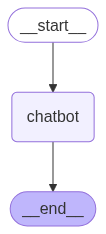

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 8. 챗봇 실행

In [39]:
# You can exit the chat loop at any time by typing `quit`, `exit`, or `q`.

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("또 만나요!")
            break
        stream_graph_updates(user_input)
    except:
        # input()을 사용할 수 없는 경우의 대체 처리(fallback)
        user_input = "지구에서 달까지의 거리를 알려줘?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  지구의 둘레는


Assistant: 지구의 둘레는 약 40,075킬로미터(24,901마일)입니다. 이는 적도를 기준으로 한 측정값이며, 극을 기준으로 측정할 경우 약 40,008킬로미터(24,860마일)입니다. 지구는 완벽한 구형이 아니고 약간 편평한 형태를 가지고 있기 때문에, 둘레는 측정하는 위치에 따라 다소 차이가 있습니다.


User:  지구의 중력은 얼마인가


Assistant: 지구의 중력 가속도는 평균적으로 약 9.81 m/s²입니다. 이는 지구 표면에서 물체가 자유 낙하할 때의 가속도를 나타내며, 지역에 따라 약간의 차이가 있을 수 있습니다. 예를 들어, 고도가 높거나 지구의 중심에서 멀어질수록 중력 가속도는 약간 감소합니다.


User:  quit


또 만나요!


## 9. 전체 코드

In [ ]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()